# Shopee - Detecting Product Similarity (Texts, Images, and Phash)
The task of this competition is to "build a model that predicts which items are the same products." We tackle this task by implementing KNN to group similar products by their title and images, and [image phash](https://en.wikipedia.org/wiki/Perceptual_hashing). We also use RAPIDS to accelerate KNN computations on the GPU. A huge thanks to the authors of the following kernel as well.
* Chris Deoette - [[PART 2] - RAPIDS TfidfVectorizer - [CV 0.700]](https://www.kaggle.com/cdeotte/part-2-rapids-tfidfvectorizer-cv-0-700/notebook#Use-Image-Embeddings)

# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math
import tensorflow as tf
import sys
import gc
import math
from tqdm import tqdm

## RAPIDS Installation & Imports
Kaggle has the 0.16 version of RAPIDS installed, but this version's `fit` and `fit_transform` methods [do not support sparse cupy matrices](https://www.kaggle.com/c/shopee-product-matching/discussion/230152) like more recent versions. It only supports dense matrices which require much more memory, so we install version 0.18 in order to save GPU memory.

In [2]:
!cp ../input/rapids/rapids.0.18.0 /opt/conda/envs/rapids.tar.gz
!cd /opt/conda/envs/ && tar -xzvf rapids.tar.gz > /dev/null
sys.path = ["/opt/conda/envs/rapids/lib/python3.7/site-packages"] + sys.path
sys.path = ["/opt/conda/envs/rapids/lib/python3.7"] + sys.path
sys.path = ["/opt/conda/envs/rapids/lib"] + sys.path 
!cp /opt/conda/envs/rapids/lib/libxgboost.so /opt/conda/lib/
print('RAPIDS 0.18 installation complete')

RAPIDS 0.18 installation complete


In [3]:
import cuml, cudf, cupy
from cuml.feature_extraction.text import TfidfVectorizer

# Examine Data
## Load Data

In [4]:
train = pd.read_csv('../input/shopee-product-matching/train.csv')
test = pd.read_csv('../input/shopee-product-matching/test.csv')
submission = pd.read_csv('../input/shopee-product-matching/sample_submission.csv')

print('Train shape: {}'.format(train.shape))
train.head()

Train shape: (34250, 5)


,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069


In [5]:
print('Test shape: {}'.format(test.shape))
test.head()

Test shape: (3, 4)


,posting_id,image,image_phash,title
0,test_2255846744,0006c8e5462ae52167402bac1c2e916e.jpg,ecc292392dc7687a,Edufuntoys - CHARACTER PHONE ada lampu dan mus...
1,test_3588702337,0007585c4d0f932859339129f709bfdc.jpg,e9968f60d2699e2c,(Beli 1 Free Spatula) Masker Komedo | Blackhea...
2,test_4015706929,0008377d3662e83ef44e1881af38b879.jpg,ba81c17e3581cabe,READY Lemonilo Mie instant sehat kuah dan goreng


In [6]:
print('Submission shape: {}'.format(submission.shape))
submission.head()

Submission shape: (3, 2)


,posting_id,matches
0,test_2255846744,test_2255846744
1,test_3588702337,test_3588702337
2,test_4015706929,test_4015706929


## Check Samples

In [7]:
def show_samples(data_df, num, title, img_path = '../input/shopee-product-matching/train_images/'):
    cols = 6
    rows = math.ceil(num / cols)
    height = 5 * rows
    fig, axs = plt.subplots(rows, cols, figsize = (20, height))
    fig.suptitle('{}\n'.format(title), fontsize = 25)
    for row in range(rows):
        for col in range(cols):     
            if rows > 1:
                ax = axs[row, col]
            else:
                ax = axs[col]
                
            ax.axis('off')
            
            df_row = col + row * cols # examine row by row for dataframe
            title = data_df.iloc[df_row, 3]
            title_with_return = ''
            for i, ch in enumerate(title):
                title_with_return += ch
                if (i != 0) & (i % 20 == 0): 
                    title_with_return += '\n'
            ax.set_title(title_with_return)
            
            posting_id = data_df.iloc[df_row, 1]
            img_bgr = cv2.imread(img_path + posting_id)
            img_rgb = cv2.cvtColor(img_bgr,  cv2.COLOR_BGR2RGB) # convert image back to RGB for visualization
            ax.imshow(img_rgb)    

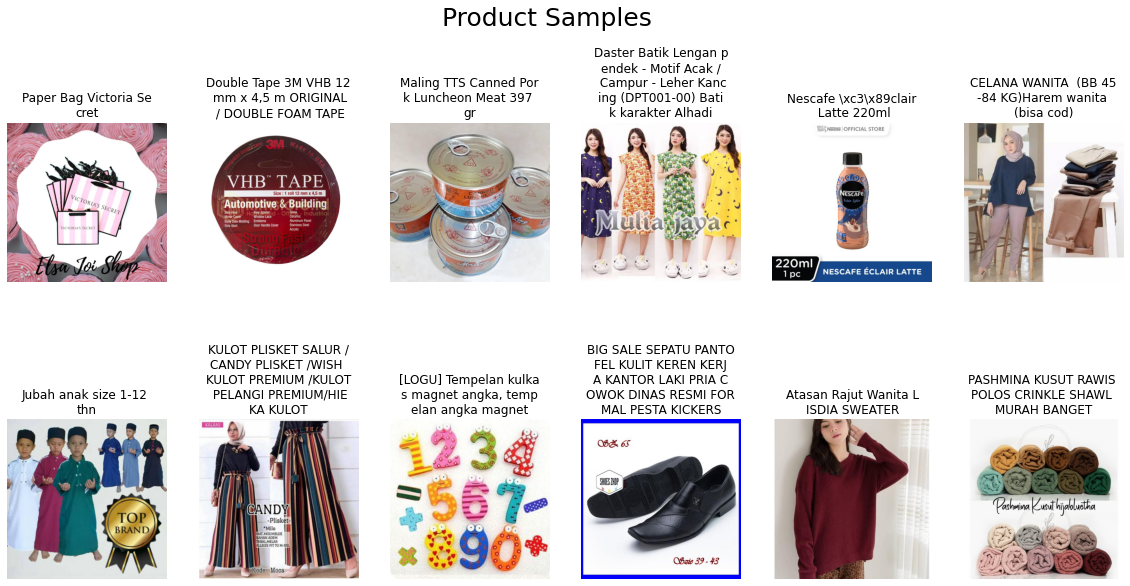

In [8]:
show_samples(data_df = train, num = 12, title = 'Product Samples')

## Check Duplicates

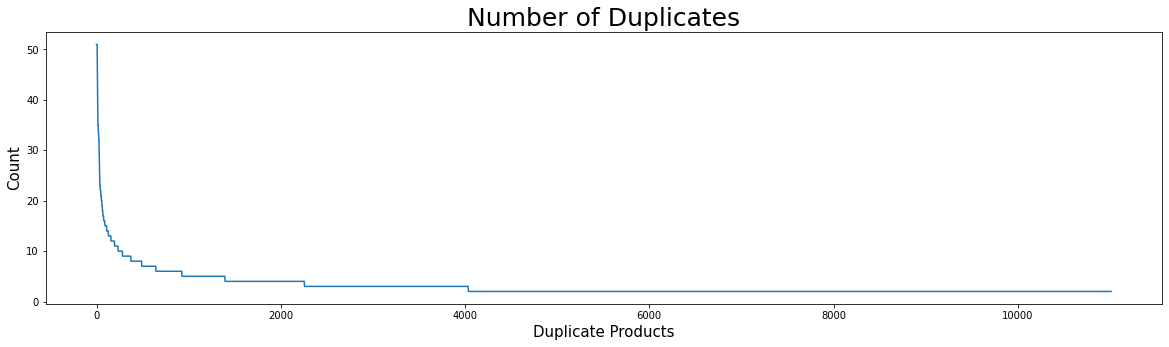

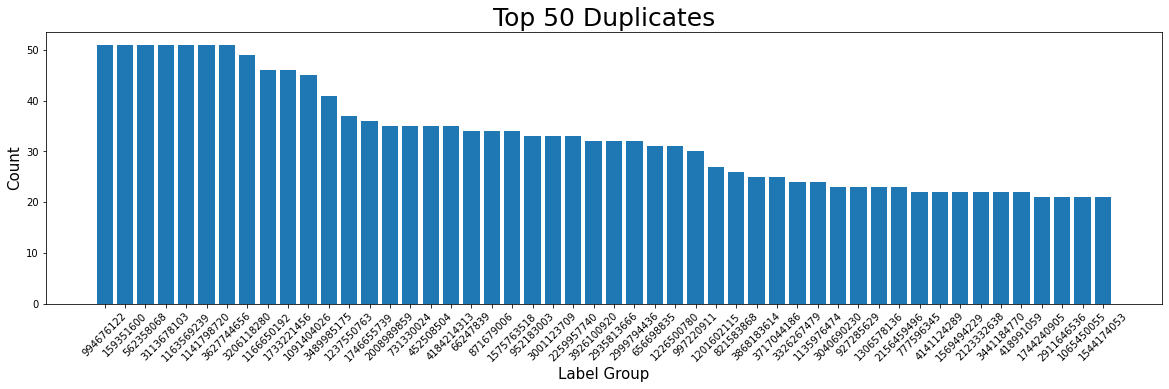

In [9]:
groups = train['label_group'].value_counts()

plt.figure(figsize = (20, 5))
plt.plot(np.arange(len(groups)),groups.values)
plt.title('Number of Duplicates',size = 25)
plt.ylabel('Count', size = 15)
plt.xlabel('Duplicate Products', size = 15)
plt.show()

plt.figure(figsize = (20, 5))
plt.bar(groups.index.values[:50].astype('str'), groups.values[:50])
plt.xticks(rotation = 45)
plt.title('Top 50 Duplicates', size = 25)
plt.ylabel('Count', size = 15)
plt.xlabel('Label Group', size = 15)
plt.show()

### Top Duplicates

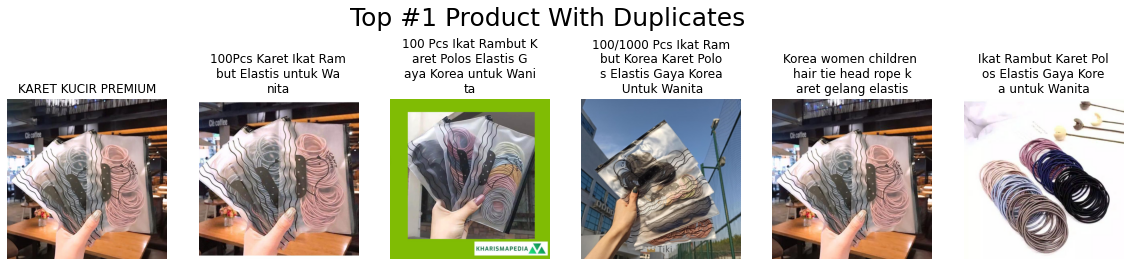

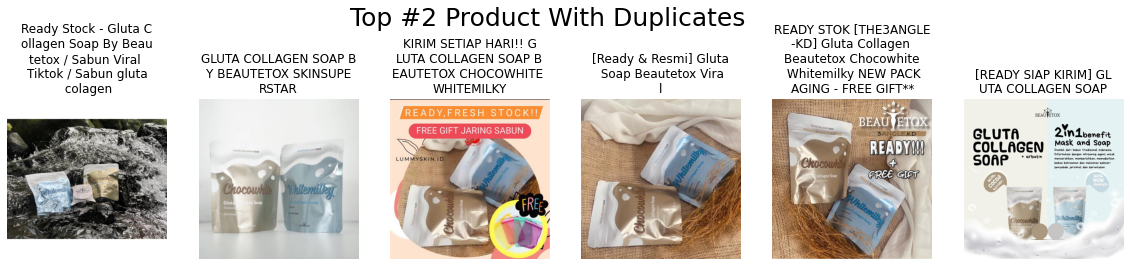

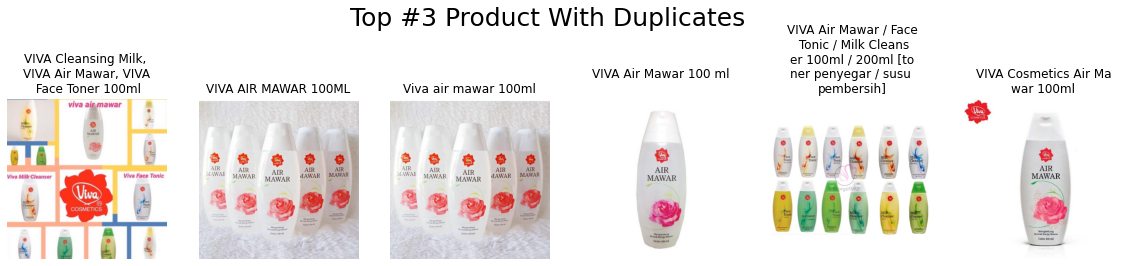

In [10]:
TOP_N = 3
COUNT = 6

top_duplicates = train['label_group'].value_counts().index[:TOP_N]
for i, duplicate_label in enumerate(top_duplicates):
    duplicate_label_df = train.loc[train['label_group'] == duplicate_label]
    duplicate_title = 'Top #{} Product With Duplicates'.format(i + 1)
    show_samples(data_df = duplicate_label_df, num = COUNT, title = duplicate_title)

# Setup RAPIDS
We setup RAPIDS by distributing the memory limits for TensorFlow and RAPIDS. Since we perform the KNN computations on the GPU, we distribute more memory to RAPIDS.
## Setup GPU Memory

In [11]:
LIMIT = 1 # 1 GB of GPU for TensorFlow, 15 GB of GPU for RAPIDS (GPU total: 16 GB)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 1024 * LIMIT)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print('GPU is online.')
    except RuntimeError as e:
        print(e)
else:
    print('GPU is offline.')
print('TensorFlow GPU memory limit set to {} GB'.format(LIMIT))
print('RAPIDS GPU memory limit set to {} GB'.format(16 - LIMIT))

GPU is online.
TensorFlow GPU memory limit set to 1 GB
RAPIDS GPU memory limit set to 15 GB


***
# Title Predictions
## Extract Text Embeddings with Tf-idf Vectorizer
We use tf-idf [to scale down the impact of tokens that occur very frequently in a given corpus](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer). This helps the model to disregard less informative tokens and emphasize more informative ones.

In [12]:
def get_text_embeddings(text_df):
    text_gf = cudf.from_pandas(text_df)
    text_embed_model = TfidfVectorizer(
        stop_words = 'english', 
        binary = True) # binary occurence since short titles
    text_embeddings = text_embed_model.fit_transform(text_gf)
    
    return text_embeddings

In [13]:
title_embeddings = get_text_embeddings(train['title'])
title_embeddings.shape

(34250, 24939)

## Get Title Distances with KNN
We get the distances and indices of the 50 closest neighbors to each text embedding of a product's title. ([Group sizes were capped at 50, so there is no benefit to predict more than 50 matches](https://www.kaggle.com/c/shopee-product-matching/overview/evaluation)) Also, for text classification the cosine distance metric performs well since it disregards the magnitudes of the embeddings, meaning it is better at capturing similarities across varying lengths of text which is our case.

In [14]:
def knn_predict_embeddings(embeddings, metric, n_neighbors = 50):
    BATCH_SIZE = 1024 * 4
    n_texts = embeddings.shape[0]
    n_batches = math.ceil(n_texts / BATCH_SIZE)
    
    knn_model = cuml.NearestNeighbors(n_neighbors = n_neighbors, metric = metric)
    knn_model.fit(embeddings)
    
    embed_distances = np.zeros((n_texts, n_neighbors))
    embed_indices = np.zeros((n_texts, n_neighbors))

    with cuml.using_output_type('numpy'): # to output as numpy arrays
        for i in tqdm(range(n_batches)):
            a = i * BATCH_SIZE
            b = min((i + 1) * BATCH_SIZE, n_texts)
            distances, indices = knn_model.kneighbors(embeddings[a:b])
            embed_distances[a:b] = distances
            embed_indices[a:b] = indices
        
    return embed_distances, embed_indices

In [15]:
title_distances, title_indices = knn_predict_embeddings(title_embeddings, 'cosine')
del title_embeddings

100%|██████████| 9/9 [00:01<00:00,  5.06it/s]


### Title Distance Samples
We check the distances of each neighbor from a number of samples.

In [16]:
def show_distance_samples(dist_type, distances, indices,  metric = '', n_items = 3, n_neighbors = 5, random = False):
    for i in range(n_items): 
        if random: 
            i = np.random.randint(0, len(train))  
        item_title = train.loc[indices[i, 0], 'title']
        
        plt.figure(figsize=(15,3))
        plt.plot(np.arange(50), distances[i,],'o-')
        plt.title('{} Distances From "{}" to Neighbors'.format(dist_type, item_title),size=16)
        plt.ylabel('{} Distance'.format(metric),size = 20)
        plt.xlabel('Closest 50 Neighbors',size = 15)
        plt.show()

        print(train.loc[indices[i, :n_neighbors],['title','label_group']] )

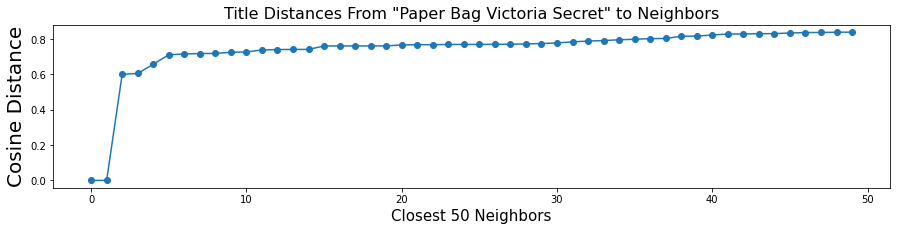

                                                     title  label_group
0.0                              Paper Bag Victoria Secret    249114794
33161.0                          PAPER BAG VICTORIA SECRET    249114794
9219.0                             PAPER BAG THE BODY SHOP    471581622
25386.0  READY! GRATIS ISI ULANG! Pengharum parfum mobi...    866425052
31159.0                      Paper Bag The Body Shop Small    471581622


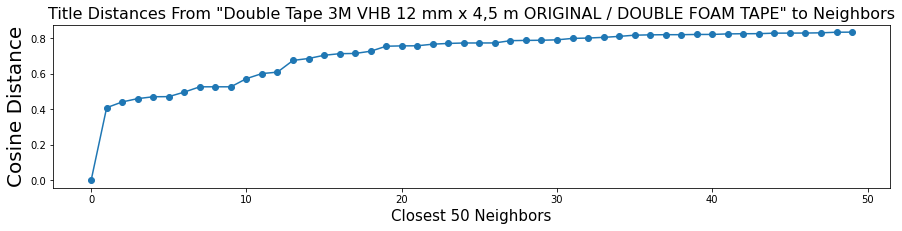

                                                     title  label_group
1.0      Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...   2937985045
18683.0  Double Tape VHB 3M ORIGINAL 12mm x 4.5mm Busa ...   2937985045
23593.0  Double Tape 3M 4900 VHB 24 mm x 4.5m tebal 1.1...   2819310070
25199.0  3M VHB 12mm x 4.5m Double Tape Foam Merah Otom...   2819310070
194.0    3M VHB Double Tape Automotive 4900 tebal 1.1 m...   2819310070


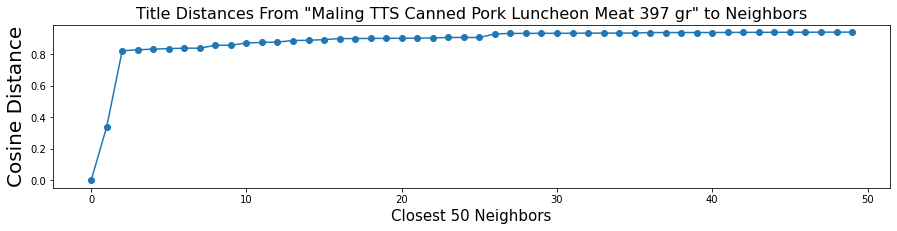

                                               title  label_group
2.0      Maling TTS Canned Pork Luncheon Meat 397 gr   2395904891
15668.0      Maling Ham Pork Luncheon Meat TTS 397gr   2395904891
6353.0              MEAT GRINDER / PENGGILING DAGING   3760480756
25580.0                  Samcan babi atau Pork Belly   2572087261
205.0                         M031 Alarm anti maling   1943235893


In [17]:
show_distance_samples('Title', title_distances, title_indices, 'Cosine')

### Extract Match Title Distances
We extract the distances of neighbors which are true duplicate matches of each product by grouping them according to each `label_group`.

In [18]:
def show_match_distances(title, distances, indices):
    match_distances = []
    for i in tqdm(range(distances.shape[0])):
        for j in range(distances.shape[1]):
            if train.loc[i, 'label_group'] == train.loc[indices[i, j], 'label_group']:
                match_distances.append(distances[i, j])
    if type(match_distances) != list:
        match_distances = [dist for dist_list in match_distances for dist in dist_list]
    plt.hist(match_distances, bins = 20)
    plt.title('{} Neighbor Distance Distribution'.format(title), size = 20)
    plt.show()
    print(pd.DataFrame(match_distances, columns=['distances']).describe())
    del match_distances

def get_match_distances(distances, indices):
    match_distances = []
    for i in tqdm(range(distances.shape[0])):
        for j in range(distances.shape[1]):
            if train.loc[i, 'label_group'] == train.loc[indices[i, j], 'label_group']:
                match_distances.append(distances[i, j])
    return match_distances

def show_match_distance_distribution(title, match_distances):
    if type(match_distances) != list:
        match_distances = [dist for dist_list in match_distances for dist in dist_list]
    plt.hist(match_distances, bins = 20)
    plt.title('{} Neighbor Distance Distribution'.format(title), size = 20)
    plt.show()
    print(pd.DataFrame(match_distances, columns=['distances']).describe())

100%|██████████| 34250/34250 [02:01<00:00, 281.44it/s]


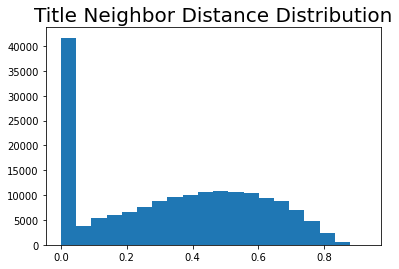

           distances
count  174877.000000
mean        0.340268
std         0.254134
min         0.000000
25%         0.074699
50%         0.359804
75%         0.553153
max         0.925008


In [19]:
show_match_distances('Title', title_distances, title_indices)

## Determine Best Title Distance
We need to decide upon a maximum distance in order to predict whether a certain neighbor is a duplicate of the product or not. To do so we calculate the mean **f1 score,** which is this competition's evluation metric, of the title predictions based on different maximum distances.

### Setup Target Values
We setup the target values by grouping every product to each `label_group`.

In [20]:
target_dict = train.groupby('label_group')['posting_id'].agg('unique').to_dict()
train['target'] = train['label_group'].map(target_dict)

### F1 Score Metric
We create a function to calculate the f1 score of each prediction.

In [21]:
def get_f1_score(row, pred_col):
    true_preds = len(np.intersect1d(row['target'], row[pred_col + '_pred']))
    f1_score = (2 * true_preds) / (len(row['target']) + len(row[pred_col + '_pred']))
           # = 2 * TP / ((2 * TP) + FN + FP) 
           # = 2 * TP / (TP + TP + FN + FP) 
           # = 2 * TP / ((TP + FN) + (TP + FP)) 
           # = 2 * TP / (len(target) + len(predictions))
    return f1_score

### Make Predictions and Choose Max Title Distance
We make predictions on various maximum distances and find the distance obtaining the highest f1 score.

In [22]:
def get_predictions(data_df, distances, indices, max_distance):
    predictions = []
    for i in tqdm(range(distances.shape[0])): 
        pred_distances = np.where(distances[i] < max_distance)[0]
        pred_indices = indices[i, pred_distances]
        row_pred = data_df.iloc[pred_indices]['posting_id'].values.tolist()
        predictions.append(row_pred)
    return predictions

def show_max_distance_f1_scores(distances, indices, max_distances, pred_col):
    for max_distance in max_distances:
        train[pred_col + '_pred'] = get_predictions(train, distances, indices, max_distance)
        train['f1_score_' + pred_col] = train.apply(get_f1_score, axis = 'columns', pred_col = pred_col)
        print('{} max distance: {}, {} f1 score = {}'.format(pred_col, max_distance, pred_col, train['f1_score_' + pred_col].mean()))
    train.drop(columns = 'f1_score_' + pred_col, inplace = True)

In [23]:
MAX_TITLE_DISTANCES = [0.46861,
                       0.46862,
                       0.46863,
                       0.46864,
                       0.46865]

show_max_distance_f1_scores(title_distances, title_indices, MAX_TITLE_DISTANCES, 'title')

  0%|          | 161/34250 [00:00<00:21, 1605.38it/s]

title max distance: 0.46861, title f1 score = 0.6610409991561331


  1%|          | 207/34250 [00:00<00:16, 2067.80it/s]

title max distance: 0.46862, title f1 score = 0.6610367088182256


  0%|          | 131/34250 [00:00<00:27, 1230.21it/s]

title max distance: 0.46863, title f1 score = 0.6610468772375611


  0%|          | 122/34250 [00:00<00:28, 1213.92it/s]

title max distance: 0.46864, title f1 score = 0.6610249933206823


100%|██████████| 34250/34250 [00:19<00:00, 1791.40it/s]


title max distance: 0.46865, title f1 score = 0.6610304203654924


The maximum distance value of `0.46863` obtained the highest f1 score, so we use this distance for our final predictions.

In [24]:
MAX_TITLE_DISTANCE = 0.46863 # best f1 score of 0.6610465706375579

## Attach Title Predictions

In [25]:
train['title_pred'] = get_predictions(train, title_distances, title_indices, MAX_TITLE_DISTANCE)
del title_distances, title_indices
_ = gc.collect()
train.head()

100%|██████████| 34250/34250 [00:16<00:00, 2061.90it/s]


,posting_id,image,image_phash,title,label_group,target,title_pred
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,"[train_129225211, train_2278313361]","[train_129225211, train_2278313361]"
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,"[train_3386243561, train_3423213080]","[train_3386243561, train_3423213080, train_183..."
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,"[train_2288590299, train_3803689425]","[train_2288590299, train_3803689425]"
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,"[train_2406599165, train_3342059966]","[train_1744956981, train_2406599165, train_352..."
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,"[train_3369186413, train_921438619]",[train_3369186413]


***
# Image Predictions
## Create Data Generator
We create a data generator to pass on the image data to our embedding model in batches to prevent memory errors.

In [26]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, df, img_size, batch_size, path): 
        self.df = df
        self.img_size = img_size
        self.batch_size = batch_size
        self.path = path
        self.indexes = np.arange(len(self.df))
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        ct = len(self.df) // self.batch_size
        ct += int(((len(self.df)) % self.batch_size) != 0)
        return ct

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        X = self.__data_generation(indexes)
        return X
            
    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' 
        X = np.zeros((len(indexes), self.img_size, self.img_size, 3), dtype = 'float32')
        df = self.df.iloc[indexes]
        for i,(index, row) in enumerate(df.iteritems()):
            img = cv2.imread(self.path + row)
            X[i,] = cv2.resize(img, (self.img_size, self.img_size)) 
        return X

## Extract Image Embeddings with Pretrained Model
We use the EfficientNetB0 model to extract image features as vectors to use for KNN. Since submissions must disable internet connection, we need to load the model weights as an input file.

In [27]:
def get_image_embeddings(image_df, image_path):
    image_embed_model = tf.keras.applications.EfficientNetB0( # image distances most evenly distributed among pretrained models
        weights = '../input/shopee-data/efficientnetb0_notop.h5', # same as calling 'imagenet', but need file import because internet must be disabled
        include_top = False, 
        pooling = 'avg', 
        input_shape = None)
    
    n_images = image_df.shape[0]
    n_features = image_embed_model.layers[-1].output_shape[1] # size of final output layer
    image_embeddings = np.zeros((n_images, n_features))
    
    input_img_size = 256 # input size of EfficientNetB0
    BATCH_SIZE = 1024 * 4
    EPOCHS = math.ceil(n_images / BATCH_SIZE)
    for i in tqdm(range(EPOCHS)):
        a = i * BATCH_SIZE
        b = min((i + 1) * BATCH_SIZE, n_images)

        image_gen = DataGenerator(df = image_df.iloc[a:b], img_size = input_img_size, batch_size = 32, path = image_path)
        batch_embeddings = image_embed_model.predict(image_gen, verbose = 1, use_multiprocessing = True, workers = 4)
        image_embeddings[a:b] = batch_embeddings
    
    return image_embeddings

In [28]:
TRAIN_PATH = '../input/shopee-product-matching/train_images/'

image_embeddings = get_image_embeddings(train['image'], TRAIN_PATH)
image_embeddings.shape

  0%|          | 0/9 [00:00<?, ?it/s]

128/128 [==============================] - 46s 294ms/step


 11%|█         | 1/9 [00:46<06:12, 46.58s/it]

128/128 [==============================] - 44s 337ms/step


 22%|██▏       | 2/9 [01:31<05:19, 45.69s/it]

128/128 [==============================] - 43s 327ms/step


 33%|███▎      | 3/9 [02:15<04:28, 44.77s/it]

128/128 [==============================] - 43s 325ms/step


 44%|████▍     | 4/9 [02:59<03:42, 44.43s/it]

128/128 [==============================] - 47s 339ms/step


 56%|█████▌    | 5/9 [03:47<03:03, 45.83s/it]

128/128 [==============================] - 43s 323ms/step


 67%|██████▋   | 6/9 [04:31<02:15, 45.08s/it]

128/128 [==============================] - 45s 340ms/step


 78%|███████▊  | 7/9 [05:16<01:30, 45.26s/it]

128/128 [==============================] - 43s 327ms/step


 89%|████████▉ | 8/9 [06:00<00:44, 44.81s/it]

47/47 [==============================] - 16s 315ms/step


100%|██████████| 9/9 [06:17<00:00, 41.90s/it]


(34250, 1280)

## Get Image Distances with KNN
Like what we did for the titles, we get the distances and indices of the 50 closest neighbors to each image embedding of a product's image. This time we use euclidean distance.

In [29]:
image_distances, image_indices = knn_predict_embeddings(image_embeddings, 'euclidean')
del image_embeddings

100%|██████████| 9/9 [00:02<00:00,  3.70it/s]


### Text Distance Samples
We check the distances of each neighbor from a number of samples.

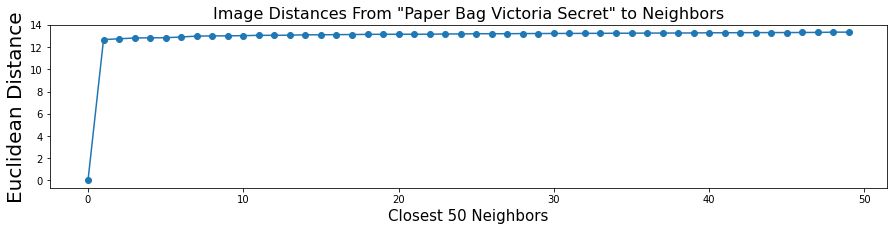

                                                     title  label_group
0.0                              Paper Bag Victoria Secret    249114794
7111.0                                      Kaos Grey Girl   3437655821
24791.0  Baju Kaos Jersey Gaming AURA FIRE ML,PUBGM,FRE...   1365941543
7057.0                                    TSHIRT GREY GIRL   3437655821
583.0    DaveCollection - Kaos Pria Kaos distro IMMORTA...   3806704121


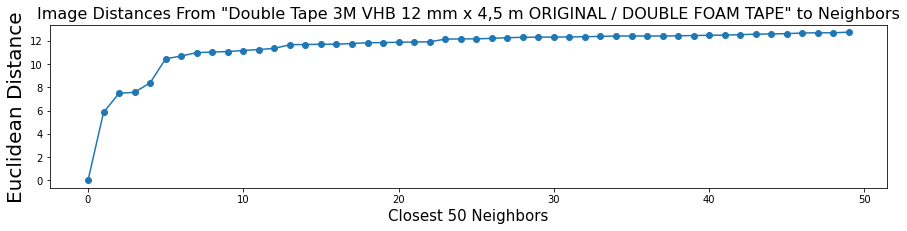

                                                     title  label_group
1.0      Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...   2937985045
18683.0  Double Tape VHB 3M ORIGINAL 12mm x 4.5mm Busa ...   2937985045
469.0    3M VHB Double Tape Automotive 4900 tebal 1.1 m...   2819310070
194.0    3M VHB Double Tape Automotive 4900 tebal 1.1 m...   2819310070
25199.0  3M VHB 12mm x 4.5m Double Tape Foam Merah Otom...   2819310070


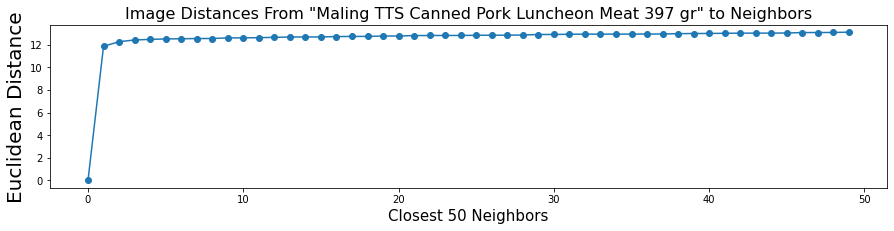

                                                     title  label_group
2.0            Maling TTS Canned Pork Luncheon Meat 397 gr   2395904891
19467.0         BPOM MISSHA Premium Cica Aloe shooting gel    454862819
7973.0   [ BPOM ] MISSHA Premium Cica Aloe Soothing Gel...    454862819
11059.0  BEEME Pelembab Serbaguna (Healing & Nourishing...   3583237905
22056.0                   SUNCARE CREAM THERASKIN SUNBLOCK    348276014


In [30]:
show_distance_samples('Image', image_distances, image_indices, 'Euclidean')

### Extract Match Image Distances
We extract the distances of neighbors which are true duplicate matches of each product by grouping them according to each `label_group`.

100%|██████████| 34250/34250 [02:04<00:00, 275.40it/s]


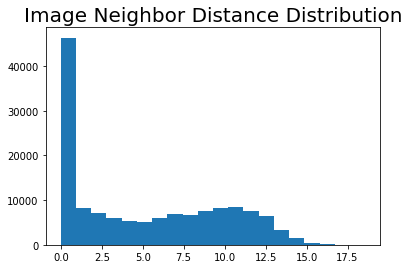

           distances
count  141339.000000
mean        5.079418
std         4.684480
min         0.000000
25%         0.014616
50%         4.239291
75%         9.404415
max        18.576672


In [31]:
show_match_distances('Image', image_distances, image_indices)

## Determine Best Image Distance
We need to decide upon a maximum distance in order to predict whether a certain neighbor is a duplicate of the product or not. To do so we calculate the mean **f1 score,** which is this competition's evluation metric, of the image predictions based on different maximum distances.

In [32]:
MAX_IMAGE_DISTANCES = [6.88564,
                       6.88566,
                       6.88568,
                       6.88570,
                       6.88572]

show_max_distance_f1_scores(image_distances, image_indices, MAX_IMAGE_DISTANCES, 'image')

  1%|          | 185/34250 [00:00<00:18, 1844.20it/s]

image max distance: 6.88564, image f1 score = 0.646956185076685


  1%|          | 208/34250 [00:00<00:16, 2075.27it/s]

image max distance: 6.88566, image f1 score = 0.6469574990306197


  0%|          | 139/34250 [00:00<00:24, 1380.55it/s]

image max distance: 6.88568, image f1 score = 0.6469574990306197


  1%|          | 378/34250 [00:00<00:17, 1921.43it/s]

image max distance: 6.8857, image f1 score = 0.6469574990306197


100%|██████████| 34250/34250 [00:18<00:00, 1827.95it/s]


image max distance: 6.88572, image f1 score = 0.6469568388569813


The maximum distance value of `6.88568` obtained the highest f1 score, so we use this distance for our final predictions.

In [33]:
MAX_IMAGE_DISTANCE = 6.88568 # best f1 score of 0.6469574990306197

## Attach Image Predictions

In [34]:
train['image_pred'] = get_predictions(train, image_distances, image_indices, MAX_IMAGE_DISTANCE)
del image_distances, image_indices
_ = gc.collect()
train.head()

100%|██████████| 34250/34250 [00:16<00:00, 2036.83it/s]


,posting_id,image,image_phash,title,label_group,target,title_pred,image_pred
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,"[train_129225211, train_2278313361]","[train_129225211, train_2278313361]",[train_129225211]
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,"[train_3386243561, train_3423213080]","[train_3386243561, train_3423213080, train_183...","[train_3386243561, train_3423213080]"
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,"[train_2288590299, train_3803689425]","[train_2288590299, train_3803689425]",[train_2288590299]
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,"[train_2406599165, train_3342059966]","[train_1744956981, train_2406599165, train_352...",[train_2406599165]
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,"[train_3369186413, train_921438619]",[train_3369186413],"[train_3369186413, train_921438619]"


***
# Phash Predictions
We use the [perceptual hashes](https://en.wikipedia.org/wiki/Perceptual_hashing) of the product images as duplicate predictions by grouping them together.

In [35]:
phash_dict = train.groupby('image_phash').posting_id.agg('unique').to_dict()
train['phash_pred'] = train.image_phash.map(phash_dict)
del phash_dict
_ = gc.collect()
train.head()

,posting_id,image,image_phash,title,label_group,target,title_pred,image_pred,phash_pred
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,"[train_129225211, train_2278313361]","[train_129225211, train_2278313361]",[train_129225211],[train_129225211]
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,"[train_3386243561, train_3423213080]","[train_3386243561, train_3423213080, train_183...","[train_3386243561, train_3423213080]",[train_3386243561]
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,"[train_2288590299, train_3803689425]","[train_2288590299, train_3803689425]",[train_2288590299],[train_2288590299]
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,"[train_2406599165, train_3342059966]","[train_1744956981, train_2406599165, train_352...",[train_2406599165],[train_2406599165]
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,"[train_3369186413, train_921438619]",[train_3369186413],"[train_3369186413, train_921438619]",[train_3369186413]


***
# Compute Validation F1 Score
We combine the three predictions we have made to obtain a single match prediction to evalute our model.

In [36]:
def combine_preds_validation(row):
    pred = np.concatenate([row['title_pred'], row['image_pred'], row['phash_pred']])
    return np.unique(pred)

def combine_preds_submission(row):
    pred = np.concatenate([row['title_pred'], row['image_pred'], row['phash_pred']])
    return ' '.join(np.unique(pred)) # submission must be in 'pred_A pred_B pred_C ...' format

In [37]:
train['match_pred'] = train.apply(combine_preds_validation, axis = 'columns')
train['f1_score'] = train.apply(get_f1_score, axis = 'columns', pred_col = 'match')
train.head()

,posting_id,image,image_phash,title,label_group,target,title_pred,image_pred,phash_pred,match_pred,f1_score
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,"[train_129225211, train_2278313361]","[train_129225211, train_2278313361]",[train_129225211],[train_129225211],"[train_129225211, train_2278313361]",1.000000
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,"[train_3386243561, train_3423213080]","[train_3386243561, train_3423213080, train_183...","[train_3386243561, train_3423213080]",[train_3386243561],"[train_1831941588, train_3386243561, train_342...",0.666667
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,"[train_2288590299, train_3803689425]","[train_2288590299, train_3803689425]",[train_2288590299],[train_2288590299],"[train_2288590299, train_3803689425]",1.000000
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,"[train_2406599165, train_3342059966]","[train_1744956981, train_2406599165, train_352...",[train_2406599165],[train_2406599165],"[train_1508100548, train_1744956981, train_204...",0.200000
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,"[train_3369186413, train_921438619]",[train_3369186413],"[train_3369186413, train_921438619]",[train_3369186413],"[train_3369186413, train_921438619]",1.000000


In [38]:
print('validation f1 score = {}'.format(train['f1_score'].mean()))

validation f1 score = 0.7248374730935733


***
# Get Test Predictions and Submit
We now perform the same process on the test set and submit these predictions to the competition. We are only provided 3 rows of data for the test set and will be provided the rest hidden upon submission. Thus, we adjust the number of neighbors accordingly.

In [39]:
test_neighbors = min(50, test.shape[0])

title_embeddings = get_text_embeddings(test['title'])

title_distances, title_indices = knn_predict_embeddings(title_embeddings, 'cosine', test_neighbors)
del title_embeddings

test['title_pred'] = get_predictions(test, title_distances, title_indices, MAX_TITLE_DISTANCE)
del title_distances, title_indices
_ = gc.collect()

TEST_PATH = '../input/shopee-product-matching/test_images/'

image_embeddings = get_image_embeddings(test['image'], TEST_PATH)

image_distances, image_indices = knn_predict_embeddings(image_embeddings, 'euclidean', test_neighbors)
del image_embeddings

test['image_pred'] = get_predictions(test, image_distances, image_indices, MAX_IMAGE_DISTANCE)
del image_distances, image_indices
_ = gc.collect()

phash_dict = test.groupby('image_phash').posting_id.agg('unique').to_dict()
test['phash_pred'] = test.image_phash.map(phash_dict)
del phash_dict
_ = gc.collect()

test['matches'] = test.apply(combine_preds_submission, axis = 'columns')
test.head()

  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


100%|██████████| 3/3 [00:00<00:00, 380.87it/s]


,posting_id,image,image_phash,title,title_pred,image_pred,phash_pred,matches
0,test_2255846744,0006c8e5462ae52167402bac1c2e916e.jpg,ecc292392dc7687a,Edufuntoys - CHARACTER PHONE ada lampu dan mus...,[test_2255846744],[test_2255846744],[test_2255846744],test_2255846744
1,test_3588702337,0007585c4d0f932859339129f709bfdc.jpg,e9968f60d2699e2c,(Beli 1 Free Spatula) Masker Komedo | Blackhea...,[test_3588702337],[test_3588702337],[test_3588702337],test_3588702337
2,test_4015706929,0008377d3662e83ef44e1881af38b879.jpg,ba81c17e3581cabe,READY Lemonilo Mie instant sehat kuah dan goreng,[test_4015706929],[test_4015706929],[test_4015706929],test_4015706929


In [40]:
test[['posting_id','matches']].to_csv('submission.csv',index = False)